In [145]:
import os
import tempfile

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
import tensorflow as tf
from IPython import get_ipython
from matplotlib import cm
from sklearn.model_selection import train_test_split
#from sklearn.manifold import Isomap
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras

pdf = pd.DataFrame

%matplotlib qt
from sklearn.metrics import confusion_matrix

# Autoreload extension
if 'autoreload' not in get_ipython().extension_manager.loaded:
    %load_ext autoreload

%autoreload 2

### Local library import
We import all the required local libraries

In [146]:
import model
from model import CalculateFeatures, SelectFeatures, REGION

## Parameter definition
We set all relevant parameters for our notebook. By convention, parameters are uppercase, while all the other variables follow Python's guidelines.

In [147]:
USE_CACHED_FEATURES = True
MAGNITUDE_THRESHOLD = 6
WINDOW_SIZE = 100

## Data import
We retrieve all the required data for the analysis.

In [148]:
# delete cached features to generate new features
if model.features_in_cache() and USE_CACHED_FEATURES:
    print("loading cached features...")
    features = model.load_features_from_cache()
    print("done.")
else:
    print("Calculating new features...")
    df = model.load_data('../../data/DATA_2.csv')
    df = df[(df.Longitude > REGION.SOUTH.x1) & (df.Latitude < REGION.SOUTH.y1) &
            (df.Longitude < REGION.SOUTH.x2) & (df.Latitude > REGION.SOUTH.y2)]
    df = df[(df.Datetime.dt.year >= 2017) & (df.Magnitude >= 3.8)]
    df_model = CalculateFeatures(df, WINDOW_SIZE, trim_features=True, mag_threshold=MAGNITUDE_THRESHOLD)
    print("New features generated.")
    features = df_model.features
    features.to_csv("../../model/features_cache/features.csv", index=False)
    print("New features saved.")

loading cached features...
done.


## Data processing

###  Feature selection

In [149]:
model.FEATURES

['elapsedT',
 'meanMag',
 'maxMag',
 'rateSqrtEnergy',
 'u',
 'c',
 'a_lsq',
 'a_mlk',
 'b_lsq',
 'b_mlk',
 'maxEMag_lsq',
 'maxEMag_mlk',
 'magDef_lsq',
 'mag_def_mlk',
 'bStd_lsq',
 'bStd_mlk',
 'grcStd_lsq',
 'grcStd_mlk',
 'pMag_lsq',
 'pMag_mlk',
 'zSeismicRateChange',
 'bSeismicRateChange',
 'lastDMaxMag']

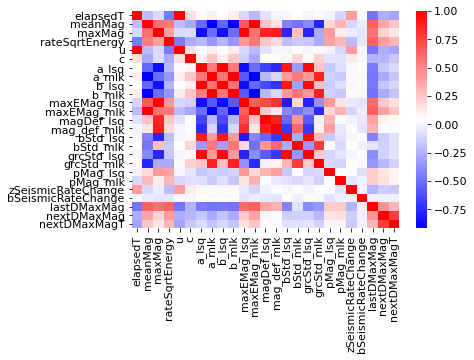

In [150]:
%matplotlib inline
plt.rcParams.update({'font.size': 11})
X = features[model.FEATURES]
Y_CONTINUOUS = features[model.TARGETS.CONTINUOUS]
Y_CATEGORICAL = features[model.TARGETS.CATEGORICAL]
selected_features = SelectFeatures(features=X, targets=Y_CONTINUOUS, corr_threshold=.99)
X = X[selected_features[0]].to_numpy()
Y_CONTINUOUS = Y_CONTINUOUS.to_numpy()
Y_CATEGORICAL = Y_CATEGORICAL.to_numpy()
corrMatrix = features[model.ALL_FEATURES].corr()
sns.heatmap(corrMatrix, yticklabels=corrMatrix.columns, xticklabels=corrMatrix.columns, cmap="bwr")
plt.show()

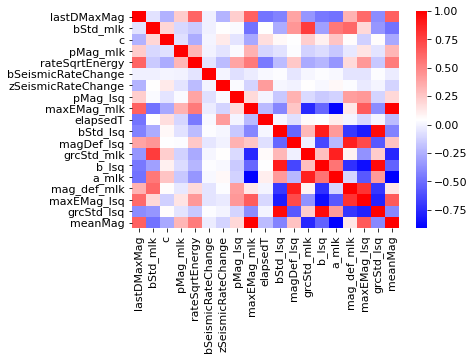

In [151]:
acx = features[selected_features[0]].corr()
sns.heatmap( acx, yticklabels=acx.columns, xticklabels=acx.columns, cmap="bwr")
plt.show()

In [152]:
neg, pos = np.bincount(Y_CATEGORICAL.T[0])
neg, pos

(26341, 12714)

###  Normalize and shorten data
(self.window_size * (T[1] - T[0])) / math.sqrt(self.window_size * T[0] + T[1])<br>

In [153]:
Y_CONTINUOUS_Scaler = MinMaxScaler()
X_Scaler = MinMaxScaler()
X_norm64 = X_Scaler.fit_transform(X)
Y_CONTINUOUS_norm64 = Y_CONTINUOUS_Scaler.fit_transform(Y_CONTINUOUS)
X_norm32 = X_norm64.astype(np.float32)
Y_CONTINUOUS_norm32 = Y_CONTINUOUS.astype(np.float32)

In [154]:
cmap = cm.get_cmap("viridis")
colors_continuous = list(map(cmap, Y_CONTINUOUS_norm64.T[0]))
color_categorical = list(map(cmap, Y_CATEGORICAL.T[0] * .90))
sizes = np.power(10, Y_CONTINUOUS_norm64.T[0])

In [155]:
RANDOM_STATE = 42
X_norm_32_train, X_norm_32_test, Y_CONTINUOUS_norm32_train, Y_CONTINUOUS_norm32_test, Y_CATEGORICAL_train, Y_CATEGORICAL_test = train_test_split(
    X_norm32, Y_CONTINUOUS_norm32, Y_CATEGORICAL, test_size=0.33, random_state=RANDOM_STATE)
X_norm_32_train, X_norm_32_val, Y_CONTINUOUS_norm32_train, Y_CONTINUOUS_norm32_val, Y_CATEGORICAL_train, Y_CATEGORICAL_val = train_test_split(
    X_norm_32_train, Y_CONTINUOUS_norm32_train, Y_CATEGORICAL_train, test_size=0.33, random_state=RANDOM_STATE)

In [156]:

def make_NN_model(metrics=model.METRICS, output_bias=None):
    if output_bias is not None:
        output_bias = tf.keras.initializers.Constant(output_bias)
    NN_model = keras.Sequential([
        keras.layers.Dense(X_norm_32_train.shape[-1], activation='relu', input_shape=(X_norm_32_train.shape[-1],)),
        keras.layers.Dropout(0.25),
        tf.keras.layers.Dense(X_norm_32_train.shape[-1], activation='relu'),
        keras.layers.Dense(1, activation='sigmoid', bias_initializer=output_bias),
    ])

    NN_model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-3),
        loss=keras.losses.BinaryCrossentropy(),
        metrics=metrics)

    return NN_model

In [157]:
NN_model = make_NN_model()
NN_model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_24 (Dense)             (None, 19)                380       
_________________________________________________________________
dropout (Dropout)            (None, 19)                0         
_________________________________________________________________
dense_25 (Dense)             (None, 19)                380       
_________________________________________________________________
dense_26 (Dense)             (None, 1)                 20        
Total params: 780
Trainable params: 780
Non-trainable params: 0
_________________________________________________________________


In [158]:
NN_model.predict(X_norm_32_train[:10])

initial_weights = os.path.join(tempfile.mkdtemp(), 'initial_weights')
NN_model.save_weights(initial_weights)


In [159]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

def plot_metrics(history):
    metrics = ['loss', 'prc', 'Precision', 'Recall']
    for n, metric in enumerate(metrics):
        name = metric.replace("_", " ").capitalize()
        plt.tight_layout()
        plt.subplot(2, 2, n + 1)
        plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
        plt.plot(history.epoch, history.history['val_' + metric],
                 color=colors[0], linestyle="--", label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(name)
        if metric == 'loss':
            plt.ylim([0, plt.ylim()[1]])
        elif metric == 'auc':
            plt.ylim([0.8, 1])
        else:
            plt.ylim([0, 1])
        plt.legend()

In [ ]:
NN_model = make_NN_model()
NN_model.load_weights(initial_weights)
baseline_history = NN_model.fit(
    X_norm_32_train,
    Y_CATEGORICAL_train,
    batch_size=model.BATCH_SIZE,
    epochs=model.EPOCHS,
    validation_data=(X_norm_32_val, Y_CATEGORICAL_val))

Epoch 1/200
5/5 [==============================] - 3s 270ms/step - loss: 0.6617 - tp: 3632.0000 - fp: 1986.0000 - tn: 18508.0000 - fn: 6294.0000 - Accuracy: 0.7278 - Precision: 0.6465 - Recall: 0.3659 - F1_score: 0.4673 - NPV: 0.7462 - R score: 0.2690 - MCC: 0.3250 - FPR: 0.9031 - auc: 0.7228 - prc: 0.6247 - val_loss: 0.6474 - val_tp: 14.0000 - val_fp: 11.0000 - val_tn: 5836.0000 - val_fn: 2774.0000 - val_Accuracy: 0.6775 - val_Precision: 0.5600 - val_Recall: 0.0050 - val_F1_score: 0.0100 - val_NPV: 0.6778 - val_R score: 0.0031 - val_MCC: 0.0273 - val_FPR: 0.9981 - val_auc: 0.5449 - val_prc: 0.3797
Epoch 2/200
5/5 [==============================] - 0s 43ms/step - loss: 0.6487 - tp: 189.0000 - fp: 210.0000 - tn: 11608

In [ ]:
def plot_cm(labels, predictions, p=0.5):
    cm = confusion_matrix(labels, predictions > p)
    plt.figure(figsize=(5, 5))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title('Confusion matrix'.format(p))
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')


In [ ]:
plot_metrics(baseline_history)

In [ ]:
train_predictions_baseline = NN_model.predict(X_norm_32_train, batch_size=model.BATCH_SIZE)
test_predictions_baseline = NN_model.predict(X_norm_32_test, batch_size=model.BATCH_SIZE)

baseline_results = NN_model.evaluate(X_norm_32_test, Y_CATEGORICAL_test,
                                     batch_size=model.BATCH_SIZE, verbose=0)
for name, value in zip(NN_model.metrics_names, baseline_results):
    print(name, ': ', value)

In [ ]:
plot_cm(Y_CATEGORICAL_test, test_predictions_baseline)

In [ ]:
%matplotlib inline
def plot_roc(name, labels, predictions, **kwargs):
  fp, tp, _ = sklearn.metrics.roc_curve(labels, predictions)

  plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
  plt.xlabel('False positives [%]')
  plt.ylabel('True positives [%]')
  plt.grid(True)
  ax = plt.gca()
  ax.set_aspect('equal')

In [ ]:
def plot_prc(name, labels, predictions, **kwargs):
    precision, recall, _ = sklearn.metrics.precision_recall_curve(labels, predictions)

    plt.plot(precision, recall, label=name, linewidth=2, **kwargs)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')

In [ ]:
plot_roc("Train Baseline", Y_CATEGORICAL_train, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", Y_CATEGORICAL_test, test_predictions_baseline, color=colors[0], linestyle='--')
plt.legend(loc='lower right')

In [ ]:
plot_prc("Train Baseline", Y_CATEGORICAL_train, train_predictions_baseline, color=colors[0])
plot_prc("Test Baseline", Y_CATEGORICAL_test, test_predictions_baseline, color=colors[0], linestyle='--')
plt.legend(loc='lower right')

#    WEIGHTED

In [ ]:
weight_for_0 = (1 / (features.shape[0] - Y_CATEGORICAL.sum())) * (features.shape[0] / 2.0)
weight_for_1 = (1 / Y_CATEGORICAL.sum()) * (features.shape[0] / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

In [ ]:
weighted_model = make_NN_model()
weighted_model.load_weights(initial_weights)

weighted_history = weighted_model.fit(
    X_norm_32_train,
    Y_CATEGORICAL_train,
    batch_size=model.BATCH_SIZE,
    epochs=model.EPOCHS,
    validation_data=(X_norm_32_val, Y_CATEGORICAL_val),
    # The class weights go here
    class_weight=class_weight)

In [ ]:
plot_metrics(weighted_history)


In [ ]:
train_predictions_weighted = weighted_model.predict(X_norm_32_train, batch_size=model.BATCH_SIZE)
test_predictions_weighted = weighted_model.predict(X_norm_32_test, batch_size=model.BATCH_SIZE)

In [ ]:
weighted_results = weighted_model.evaluate(X_norm_32_test, Y_CATEGORICAL_test,
                                           batch_size=model.BATCH_SIZE, verbose=0)
for name, value in zip(weighted_model.metrics_names, weighted_results):
    print(name, ': ', value)
print()

plot_cm(Y_CATEGORICAL_test, test_predictions_weighted)

In [ ]:
plot_roc("Train Baseline", Y_CATEGORICAL_train, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", Y_CATEGORICAL_test, test_predictions_baseline, color=colors[0], linestyle='--')
plt.legend(loc='lower right')

In [ ]:
plot_prc("Train Baseline", Y_CATEGORICAL_train, train_predictions_baseline, color=colors[0])
plot_prc("Test Baseline", Y_CATEGORICAL_test, test_predictions_baseline, color=colors[0], linestyle='--')
plt.legend(loc='lower right')

In [ ]:
pos_features = X_norm_32_train[Y_CATEGORICAL_train.T[0]]
neg_features = X_norm_32_train[~Y_CATEGORICAL_train.T[0]]

pos_labels = Y_CATEGORICAL_train[Y_CATEGORICAL_train.T[0]]
neg_labels = Y_CATEGORICAL_train[~Y_CATEGORICAL_train.T[0]]

In [ ]:
ids = np.arange(len(pos_features))
choices = np.random.choice(ids, len(neg_features))

res_pos_features = pos_features[choices]
res_pos_labels = pos_labels[choices]

res_pos_features.shape


In [ ]:
resampled_features = np.concatenate([res_pos_features, neg_features], axis=0)
resampled_labels = np.concatenate([res_pos_labels, neg_labels], axis=0)

order = np.arange(len(resampled_labels))
np.random.shuffle(order)
resampled_features = resampled_features[order]
resampled_labels = resampled_labels[order]

resampled_features.shape

In [ ]:
BUFFER_SIZE = 100000


def make_ds(features, labels):
    ds = tf.data.Dataset.from_tensor_slices((features, labels))  #.cache()
    ds = ds.shuffle(BUFFER_SIZE).repeat()
    return ds


pos_ds = make_ds(pos_features, pos_labels)
neg_ds = make_ds(neg_features, neg_labels)

In [ ]:
for features, label in pos_ds.take(1):
    print("Features:\n", features.numpy())
    print()
    print("Label: ", label.numpy())

In [ ]:
resampled_ds = tf.data.experimental.sample_from_datasets([pos_ds, neg_ds], weights=[0.5, 0.5])
resampled_ds = resampled_ds.batch(model.BATCH_SIZE).prefetch(2)


In [ ]:
for features, label in resampled_ds.take(1):
    print(label.numpy().mean())

In [ ]:
resampled_steps_per_epoch = np.ceil(2.0 * neg / model.BATCH_SIZE)
resampled_steps_per_epoch

In [ ]:
resampled_model = make_NN_model()
resampled_model.load_weights(initial_weights)

# Reset the bias to zero, since this dataset is balanced.
output_layer = resampled_model.layers[-1]
output_layer.bias.assign([0])

val_ds = tf.data.Dataset.from_tensor_slices((X_norm_32_val, Y_CATEGORICAL_val)).cache()
val_ds = val_ds.batch(model.BATCH_SIZE).prefetch(2)

resampled_history = resampled_model.fit(
    resampled_ds,
    epochs=model.EPOCHS,
    steps_per_epoch=resampled_steps_per_epoch,
    validation_data=val_ds)

In [ ]:
plot_metrics(resampled_history)

In [ ]:
train_predictions_resampled = resampled_model.predict(X_norm_32_train, batch_size=model.BATCH_SIZE)
test_predictions_resampled = resampled_model.predict(X_norm_32_test, batch_size=model.BATCH_SIZE)

In [ ]:
resampled_results = resampled_model.evaluate(X_norm_32_test, Y_CATEGORICAL_test,
                                             batch_size=model.BATCH_SIZE, verbose=0)
for name, value in zip(resampled_model.metrics_names, resampled_results):
    print(name, ': ', '%.6g' % value)
print()

plot_cm(Y_CATEGORICAL_test, test_predictions_resampled)

In [ ]:
plot_roc("Train Baseline", Y_CATEGORICAL_train, train_predictions_resampled, color=colors[0])
plot_roc("Test Baseline", Y_CATEGORICAL_test, test_predictions_resampled, color=colors[0], linestyle='--')
plt.legend(loc='lower right')

In [ ]:
plot_prc("Train Baseline", Y_CATEGORICAL_train, train_predictions_resampled, color=colors[0])
plot_prc("Test Baseline", Y_CATEGORICAL_test, test_predictions_resampled, color=colors[0], linestyle='--')
plt.legend(loc='lower right')

In [ ]:

loss :  0.393797
tp :  3000
fp :  946
tn :  7730
fn :  1213
Accuracy :  0.832493
Precision :  0.760264
Recall :  0.712082
F1_score :  0.735384
NPV :  0.864363
R score :  0.603045
MCC :  0.613741
FPR :  0.890964
auc :  0.878823
prc :  0.838272